In [1]:

import jax.random as jr
import jax.numpy as jnp
from jax.scipy.stats import multivariate_normal
from jax import Array

from dynamax.linear_gaussian_ssm import lgssm_filter
from dynamax.linear_gaussian_ssm import LinearGaussianSSM as dmax_LGSSM

import matplotlib.pyplot as plt

from feynman_kac.protocol import FeynmacKac, PFConfig, PFOutputs
from feynman_kac.tempering import TemperedPF
from feynman_kac.bootstrap import PF
from feynman_kac.model.lgssm import LGSSM_BPF

from resample.backward_sampling import LineageTracking
from utils.datasets import load_dataset

In [2]:
def exact_filter(data):
    
    # get true filter means using Kalman filter
    dmax_lgssm = dmax_LGSSM(data.train_states.shape[-1], data.train_data[0].shape[-1])
    params, _ = dmax_lgssm.initialize(
        jr.PRNGKey(0),
        initial_mean=data.params['m1'],
        initial_covariance=data.params['Q1'],
        dynamics_weights=data.params['A'],
        dynamics_covariance=data.params['Q'],
        emission_weights=data.params['C'],
        emission_covariance=data.params['R']
    )
    x, y = data.train_states[0], data.train_data[0][0]
    lgssm_posterior = lgssm_filter(params, y)
    print("Exact filter means shape: ", lgssm_posterior.filtered_means.shape)
    return lgssm_posterior


def run_bpf(key, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSM_BPF(data.params)
    
    # construct bootstrap particle filter
    bpf = PF(
        model=lgssm,
        cfg=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.5,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key=key,
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs

def tempered_bpf(key, data, N: int):

    # parametrise model with the true parameters for now
    lgssm = LGSSM_BPF(data.params)
    
    # construct bootstrap particle filter
    bpf = TemperedPF(
        model=lgssm,
        cfg=PFConfig(
            N=N,
            resample_scheme='multinomial',
            ess_threshold=0.3,
            key=jr.PRNGKey(42)
        )
    )

    # run filter
    outs = bpf.filter(
        key=key,
        obs=data.train_data[0][0]  # just using the first sequence
    )
    print("BPF particles shape: ", outs.particles.shape)
    print("BPF weights shape: ", outs.weights.shape)
    print("BPF logZ_hat: ", outs.logZ_hat)
    return outs



In [3]:
data = load_dataset('linear_large', seed=0)
data = data.standardized_data
lgssm_posterior = exact_filter(data)
x, y = data.train_states[0], data.train_data[0][0]

Exact filter means shape:  (300, 30)


In [4]:
outs = tempered_bpf(jr.PRNGKey(10), data, 5000)
outs.particles.shape, outs.weights.shape

BPF particles shape:  (300, 5000, 30)
BPF weights shape:  (300, 5000)
BPF logZ_hat:  -2352.806


((300, 5000, 30), (300, 5000))

BPF particles shape:  (300, 50000, 30)
BPF weights shape:  (300, 50000)
BPF logZ_hat:  -16942.707
weighted x_t shape:  (300, 30)
MSE from BPF to exact filter means:  0.105000705


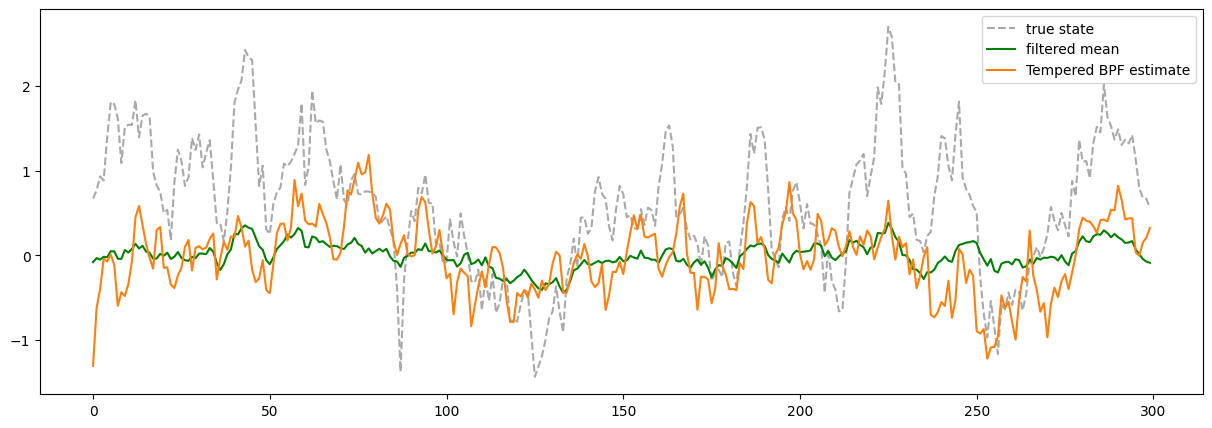

BPF particles shape:  (300, 50000, 30)
BPF weights shape:  (300, 50000)
BPF logZ_hat:  -1427.4586
weighted x_t shape:  (300, 30)
MSE from BPF to exact filter means:  0.028909659


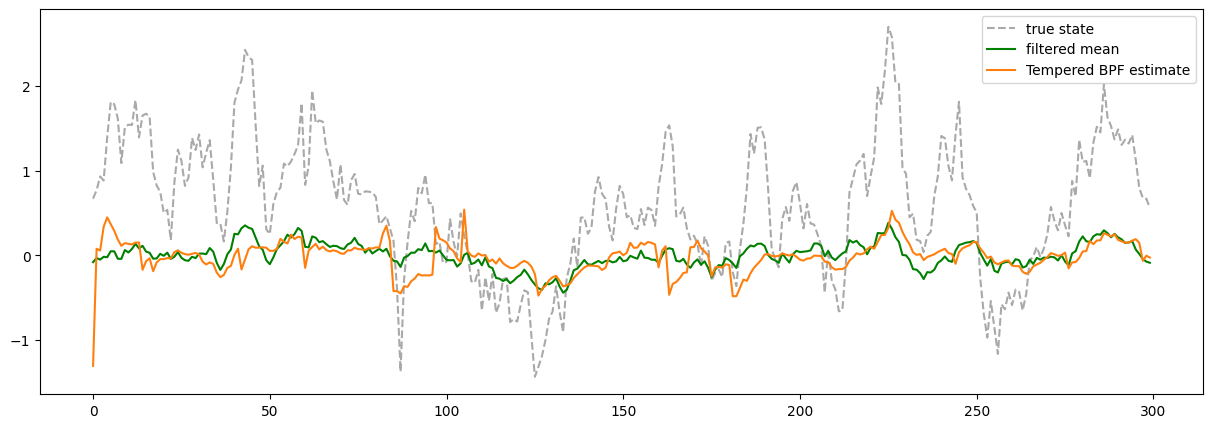

In [6]:
for fn in [run_bpf, tempered_bpf]:

    outs = fn(jr.PRNGKey(10), data, 50000)
    
    # calculate weighted estimates of state means
    x_hat = jnp.sum(outs.weights[:, :, None] * outs.particles, axis=1)
    print("weighted x_t shape: ", x_hat.shape)
    
    # calculate MSE against true filter means
    mse = jnp.mean((x_hat - lgssm_posterior.filtered_means)**2)
    print("MSE from BPF to exact filter means: ", mse)
    
    # plot results
    observation_marker_kwargs = {"marker": "o", "markerfacecolor": "none", "markeredgewidth": 2, "markersize": 8}
    fig, ax = plt.subplots(figsize=(15, 5))
    # ax.plot(y[:, 3], ls="", **observation_marker_kwargs, color="tab:green", label="observed")
    ax.plot(x[:, 3], ls="--", color="darkgrey", label="true state")
    # ax.plot(lgssm_posterior.smoothed_means[:, 3], color="blue", label="smoothed mean")
    ax.plot(lgssm_posterior.filtered_means[:, 3], color="green", label="filtered mean")
    ax.plot(x_hat[:, 3], color="tab:orange", label="Tempered BPF estimate")
    plt.legend()
    plt.show()